benign (270)


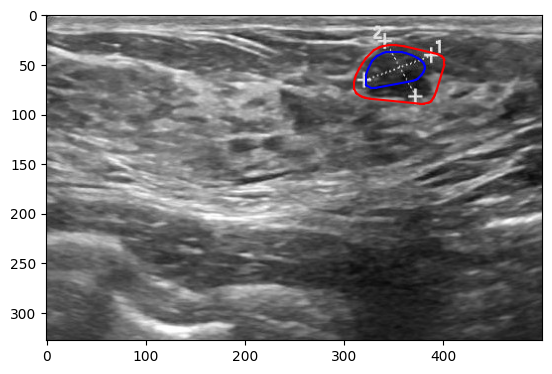

benign (111)


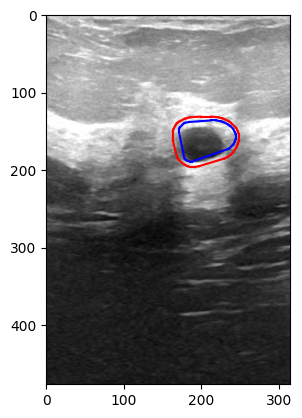

benign (118)


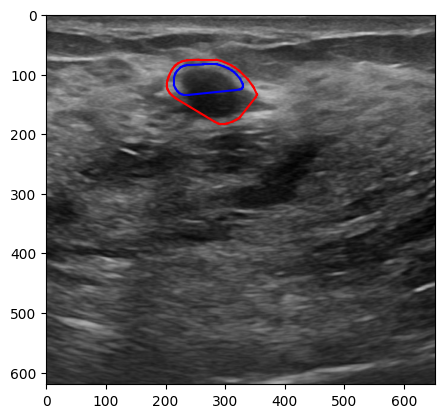

benign (126)


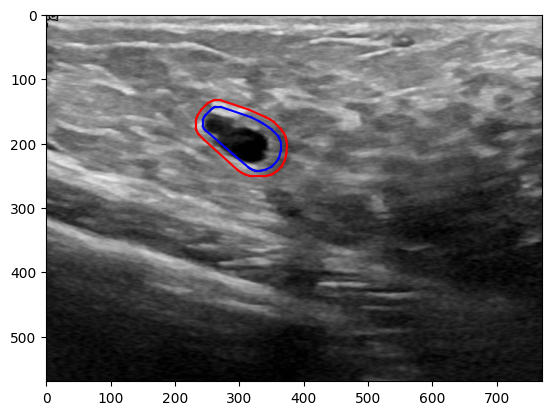

benign (341)


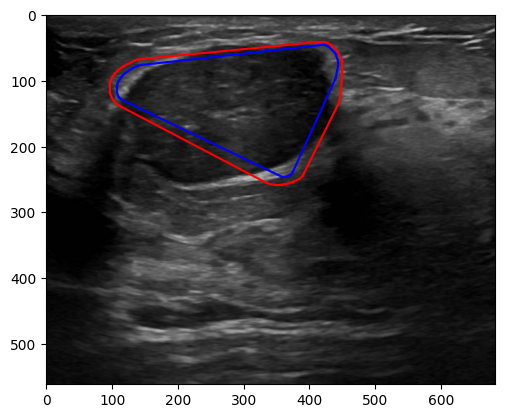

benign (271)


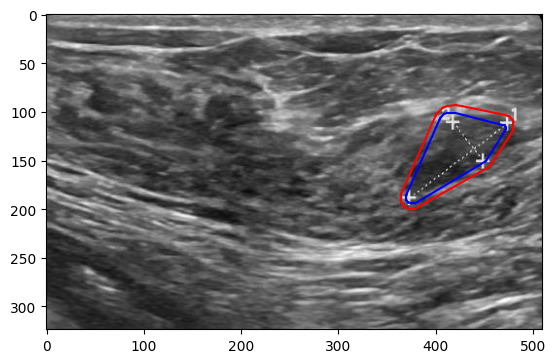

benign (12)


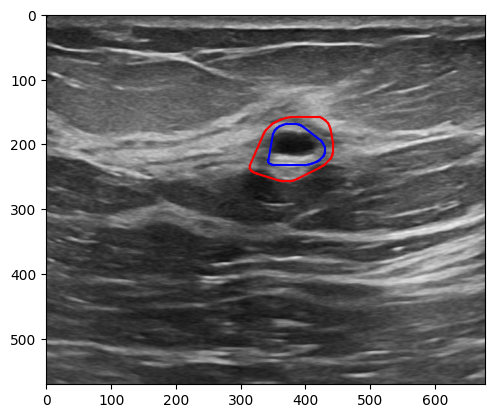

benign (186)


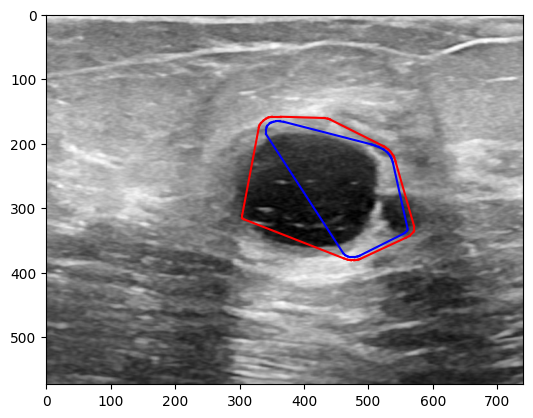

benign (417)


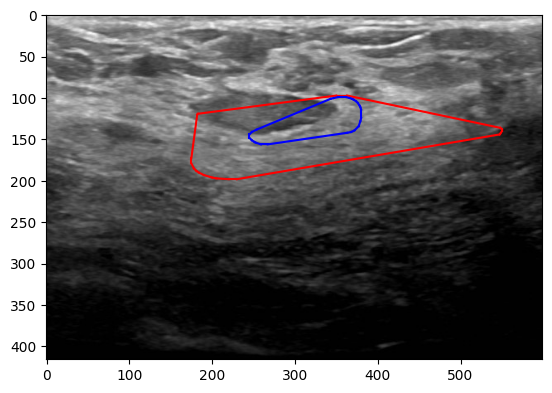

benign (129)


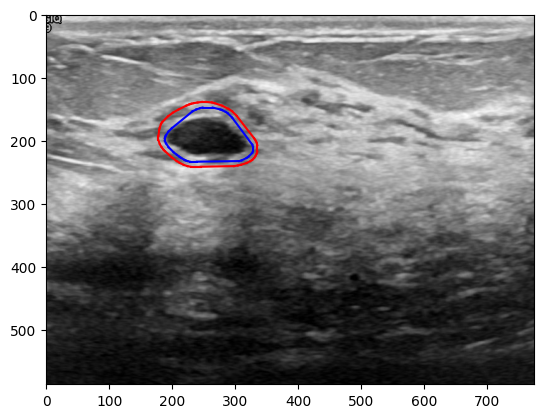

benign (334)


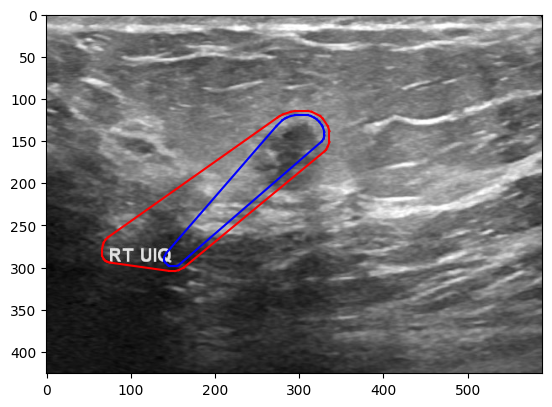

benign (313)


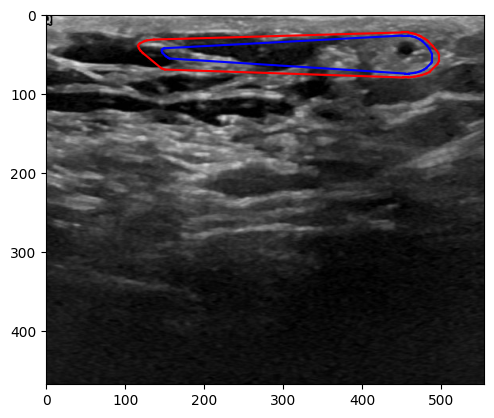

benign (59)


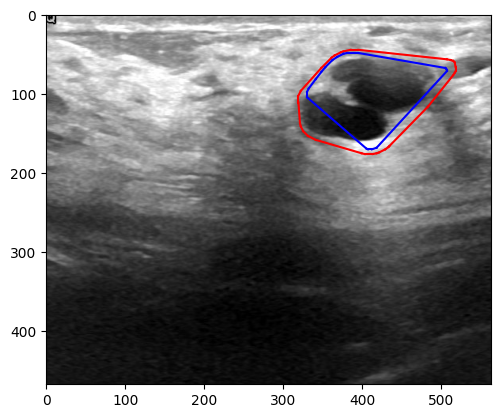

benign (378)


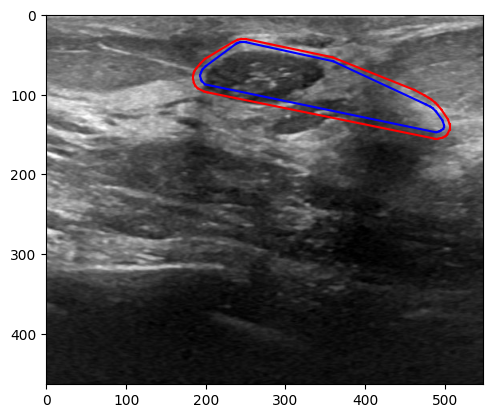

benign (150)


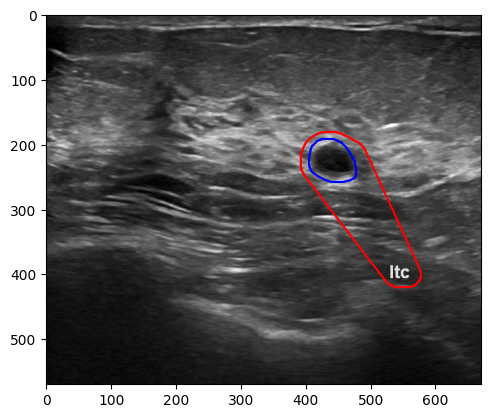

benign (277)


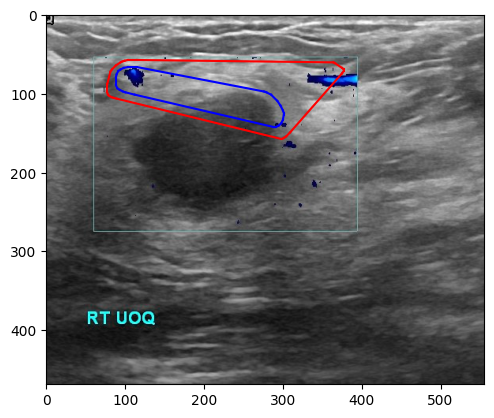

benign (278)


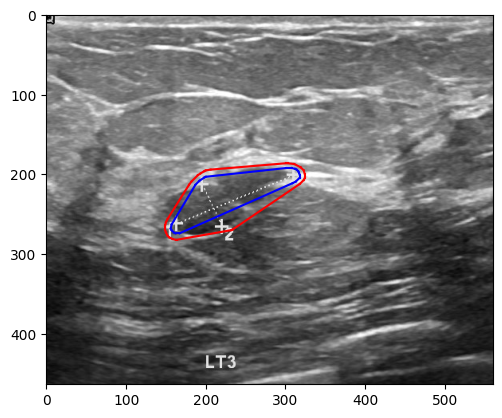

benign (345)


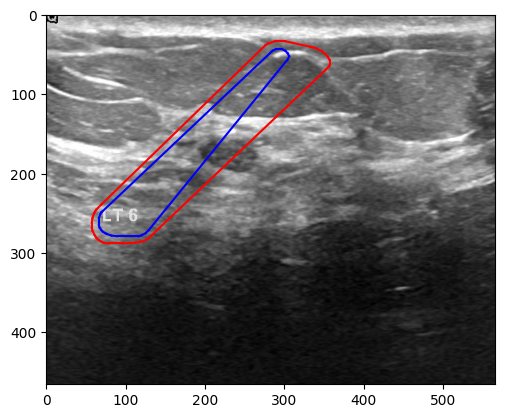

benign (51)


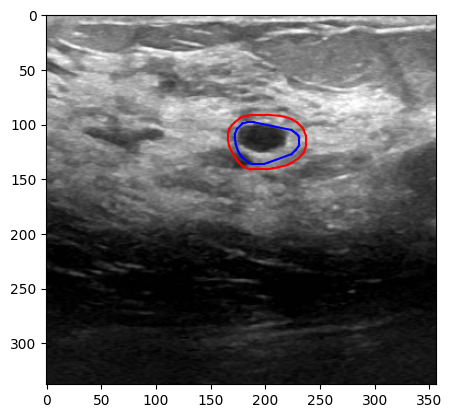

benign (120)


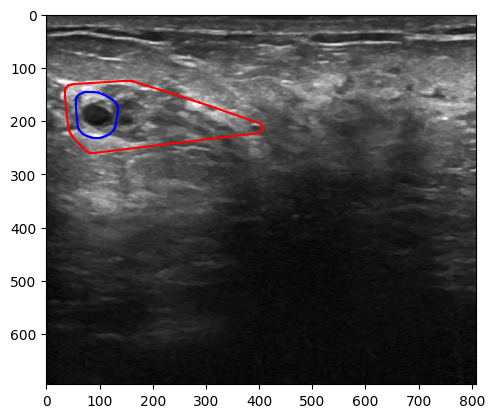

In [1]:
# the one that cover the whole tumor #benign 126
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from help.helper import merge_rec_saveFile, boundingBoxFromGT,merge_bounding_boxes,rectangle_iou
from BUS.loadData import load
from help.helper import getPathShortName
from scipy.spatial import ConvexHull


def plot_histogram(image):
    """Plot the histogram of the given image."""
    plt.hist(image.ravel(), bins=256, range=[0, 255])
    plt.title('Histogram of the Image')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
    plt.show()

def count_pixels_in_range(image, min_value, max_value):
    """Count the number of pixels in the specified range."""
    return np.sum((image >= min_value) & (image <= max_value))



def find_points_in_range(image, min_value, max_value):
    """Find the coordinates of pixels in the specified range."""
    y_coords, x_coords = np.where((image >= min_value) & (image <= max_value))
    return np.column_stack((x_coords, y_coords))


def compute_convex_hull(points):
    """Compute the convex hull of a set of points."""
    return ConvexHull(points)

def plot_convex_hull(image, hull, points):
    """Plot the image and the convex hull."""
    plt.imshow(image, cmap='gray')
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1], 'r-')
    plt.show()


def find_percent_threshold(image, percent):
    """
    Find a threshold value in the image such that the number of pixels above this 
    threshold is 20% of the total number of pixels.

    :param image: The processed image.
    :return: The threshold value.
    """
    # Calculate histogram
    hist, bins = np.histogram(image, bins=256, range=(0, 255))

    # Compute the cumulative sum from the end
    cum_sum = np.cumsum(hist[::-1])[::-1]

    # Total number of pixels
    total_pixels = image.size

    # Find the threshold index
    threshold_index = np.where(cum_sum <= total_pixels * percent)[0][0]

    # Corresponding bin value
    threshold_value = bins[threshold_index]

    return threshold_value

def plot_convex_hulls(image, points1, points2, color1='r', color2='b'):
    """
    Plot the image and the convex hulls for two sets of points.

    :param image: The image on which to plot the convex hulls.
    :param points1: The first set of points.
    :param points2: The second set of points.
    :param color1: The color for the first convex hull.
    :param color2: The color for the second convex hull.
    """
    plt.imshow(image, cmap='gray')

    # Compute and plot the first convex hull
    if len(points1) > 2:  # Convex hull requires at least 3 points
        hull1 = ConvexHull(points1)
        for simplex in hull1.simplices:
            plt.plot(points1[simplex, 0], points1[simplex, 1], color1 + '-')

    # Compute and plot the second convex hull
    if len(points2) > 2:  # Convex hull requires at least 3 points
        hull2 = ConvexHull(points2)
        for simplex in hull2.simplices:
            plt.plot(points2[simplex, 0], points2[simplex, 1], color2 + '-')

    plt.show()

def getDot(camFolder, filename):
    """
    use the file in the camfolder to visualize in the same picture
    return pic
    """

    img_name, type = getPathShortName(filename)
    print(img_name[:-4])
    image = cv2.imread(filename)
    cam_path=os.path.join(camFolder, type, img_name[:-4] + '.npy')

    loaded_data = np.load(cam_path,allow_pickle=True).item()
    cam = loaded_data['high_res']
    cam = (cam - cam.min()) / (cam.max() - cam.min()) * 255
    cam = np.uint8(cam)
    cam = cam.reshape((image.shape[0], image.shape[1]))




    # plot_histogram(cam)
    # big convex
    num=find_percent_threshold(cam, 0.025)
    # print('num', num)
    # s=count_pixels_in_range(cam, num, 255)
    # print('s',s)
    points1 = find_points_in_range(cam, num, 250)
        # Compute the convex hull
    # hull = compute_convex_hull(points)
    # Plot the image and the convex hull
    # plot_convex_hull(image, hull, points)


    num2=find_percent_threshold(cam, 0.01)
    # print('num', num)
    # s2=count_pixels_in_range(cam, num2, 255)
    # print('s',s)
    points2 = find_points_in_range(cam, num2, 250)

    plot_convex_hulls(image, points1, points2)




 

    # cam_image = cv2.applyColorMap(cam, cv2.COLORMAP_JET) 
    # # Overlay the CAM on the original image

    # cam_image = cv2.addWeighted(image,  0.8, cam_image, 0.4, 0)
    
    # cam_image_rgb = cv2.cvtColor(cam_image, cv2.COLOR_BGR2RGB)
    # plt.imshow(cam_image_rgb)  # Use 'cmap=None' for color images
    # plt.axis('off')  # Turn off axis ticks and labels
    # plt.show() 
    # return cam_image_rgb
    return 1

def readFromSet_list(file_path = '/home/lintzuh@kean.edu/BUS/AMR/record/ROI_FULLSET.txt'):
    import re
    import sys
   
    
    sys.path.append('/home/lintzuh@kean.edu/BUS/mean-teacher-medical-imaging/code')
    def getFullPathName(dataRoot, shortName):
        # input: benign (126)
        import os
        if shortName[0] == 'b':
            type = 'benign'
        elif shortName[0] == 'm':
            type = 'malignant'
        else:
            type = 'normal'

        Fp = os.path.join(dataRoot, type, shortName+'.png')
        return Fp
    imageName = []
    imageNameRec=[]
    dataroot = '/home/lintzuh@kean.edu/BUS/data/Dataset_BUSI_with_GT'

    with open(file_path, 'r') as file:
        next(file)

        for line in file:
            # Regular expression pattern to match the required fields
            pattern = r'([^,]+ \(\d+\)), \((\d+, \d+, \d+, \d+)\)'

            match = re.match(pattern, line)

            if match:
                filename = match.group(1)
                coordinates = tuple(map(int, match.group(2).split(', ')))
                


                fullFileName =getFullPathName(dataroot, filename)
                imageName.append(fullFileName)
                imageNameRec.append(coordinates)
            else:
                print('dangerous, when reading file')
    return imageName, imageNameRec

if __name__ == '__main__':

    # dataRoot = '/home/lintzuh@kean.edu/BUS/data/Dataset_BUSI_with_GT'
    # filename = 'benign (126).png'
    # fullName = os.path.join(dataRoot,'benign' ,filename)
    # print(fullName)

    # getDot('result/cam_merge', fullName)

    # # just edge benign 186
    # filename = 'benign (186).png'
    # fullName = os.path.join(dataRoot,'benign' ,filename)
    # getDot('result/cam_merge', fullName)


    train_path = '/home/lintzuh@kean.edu/BUS/AMR/record/ROI_FULLSET.txt'
    train_set, _ = readFromSet_list(train_path)
    i = 0
    for fullName in train_set:
        getDot('result/cam_merge', fullName)
        i+=1
        if i == 20:
            break